In [1]:
import pandas as pd

In [2]:
import os
os.environ['R_HOME'] = 'C:\Program Files\R\R-4.2.2'

In [3]:
#load rpy2
%load_ext rpy2.ipython

C:\Users\javte\anaconda3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [4]:
# read data
fold1 = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\multiclass_genes\sm_boruta_sorted_feat_importances_1.csv")
fold2 = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\multiclass_genes\sm_boruta_sorted_feat_importances_2.csv")
fold3 = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\multiclass_genes\sm_boruta_sorted_feat_importances_3.csv")
fold4 = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\multiclass_genes\sm_boruta_sorted_feat_importances_4.csv")
fold5 = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\multiclass_genes\sm_boruta_sorted_feat_importances_5.csv")

In [5]:
# load columns of full matrix
fullmatrix = pd.read_csv(r"C:\Users\javte\Documents\SSEF project\datasets\full_matrix\matrix_logCPMrmBatch_20221207.csv",index_col=[0])
all_genes = fullmatrix.index.to_list()

In [6]:
# get intersection of all folds
intersection = set(fold1.Feature) & set(fold2.Feature)& set(fold3.Feature)& set(fold4.Feature)& set(fold5.Feature)

In [7]:
#remove decimal point from intersection -> input
intersection = list(intersection)
intersection_input = [item.split('.', 1)[0] for item in intersection]

In [8]:
#remove decimal point from custom_bg
custom_bg = [item.split('.', 1)[0] for item in all_genes]

In [246]:
#input intersection_input and custom_bg into R
%R -i intersection_input
%R -i custom_bg

In [248]:
len(intersection_input)

2253

In [10]:
%%R
#enrichment analysis of intersection genes
library(gprofiler2)
go_enrichment <- gost(query = intersection_input, 
                organism = "hsapiens", ordered_query = FALSE, 
                multi_query = FALSE, significant = TRUE, exclude_iea = FALSE, 
                measure_underrepresentation = FALSE, evcodes = FALSE, 
                user_threshold = 0.2, correction_method = "fdr", 
                domain_scope = "custom", custom_bg = custom_bg, 
                sources = c("GO:BP", "REAC", "KEGG"), as_short_link = FALSE)
go_enrichment <- go_enrichment$result

In [243]:
%%R
#enrichment analysis of intersection genes
library(gprofiler2)
go_enrichment_noFDR <- gost(query = intersection_input, 
                organism = "hsapiens", ordered_query = FALSE, 
                multi_query = FALSE, significant = TRUE, exclude_iea = FALSE, 
                measure_underrepresentation = FALSE, evcodes = FALSE, 
                user_threshold = 0.2, #correction_method = "fdr", 
                domain_scope = "custom", custom_bg = custom_bg, 
                sources = c("GO:BP", "REAC", "KEGG"), as_short_link = FALSE)
go_enrichment_noFDR <- go_enrichment_noFDR$result

In [245]:
%%R
go_enrichment_no_FDR_filtered <- go_enrichment_noFDR %>% filter(term_size<=500)
head(go_enrichment_no_FDR_filtered)

    query significant      p_value term_size query_size intersection_size
1 query_1        TRUE 1.135816e-25       493       2251               123
2 query_1        TRUE 4.081089e-25       447       2251               115
3 query_1        TRUE 3.187142e-20       314       2251                86
4 query_1        TRUE 4.293299e-20       353       2251                92
5 query_1        TRUE 4.909996e-19       371       2251                93
6 query_1        TRUE 5.251093e-19       295       2251                81
   precision    recall    term_id source                         term_name
1 0.05464238 0.2494929 GO:0048285  GO:BP                 organelle fission
2 0.05108841 0.2572707 GO:0000280  GO:BP                  nuclear division
3 0.03820524 0.2738854 GO:0140014  GO:BP          mitotic nuclear division
4 0.04087072 0.2606232 GO:0007059  GO:BP            chromosome segregation
5 0.04131497 0.2506739 GO:0045786  GO:BP negative regulation of cell cycle
6 0.03598401 0.2745763 GO:009881

In [11]:
%%R
library(dplyr)
#dataframe of results with term_name and id
diction <- select(go_enrichment, c('term_id','term_name'))
diction <- as.data.frame(diction)


R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [12]:
%R -o diction
diction.set_index('term_id',inplace=True)

In [13]:
%%R 
#filter GO enrichment for termsize<=500 and p<=0.01
filtered_go_enrichment <- go_enrichment %>% filter(term_size <= 500, p_value<=0.01)
head(filtered_go_enrichment)

    query significant      p_value term_size query_size intersection_size
1 query_1        TRUE 3.617137e-26       493       2251               123
2 query_1        TRUE 1.206836e-25       447       2251               115
3 query_1        TRUE 5.074910e-21       314       2251                86
4 query_1        TRUE 6.583058e-21       353       2251                92
5 query_1        TRUE 7.259780e-20       371       2251                93
6 query_1        TRUE 7.496388e-20       295       2251                81
   precision    recall    term_id source                         term_name
1 0.05464238 0.2494929 GO:0048285  GO:BP                 organelle fission
2 0.05108841 0.2572707 GO:0000280  GO:BP                  nuclear division
3 0.03820524 0.2738854 GO:0140014  GO:BP          mitotic nuclear division
4 0.04087072 0.2606232 GO:0007059  GO:BP            chromosome segregation
5 0.04131497 0.2506739 GO:0045786  GO:BP negative regulation of cell cycle
6 0.03598401 0.2745763 GO:009881

In [14]:
%%R
filtered_go_enrichment <- filtered_go_enrichment %>% top_n(100, -log10(p_value))
dim(filtered_go_enrichment)

[1] 100  14


In [16]:
%%R
library(clusterProfiler)
full_gmt <- read.gmt('gprofiler_full_hsapiens.ENSG.gmt')

In [17]:
%%R
# only GO from filtered results
filtered_gmt <<- full_gmt %>% filter(term %in% filtered_go_enrichment$term_id)
length(unique(filtered_gmt$term))

[1] 99


In [18]:
%%R
#from GO enrichment results, isolate GO id and term_name columns
filtered_termnames <<- filtered_go_enrichment %>% select(term_id, term_name)
length(unique(filtered_termnames$term_id))

[1] 100


In [19]:
%%R
library(dplyr)
#runs GSEA on subtype
GSEAresult <- function(subtype){
    geneList <- read.csv(paste0("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/",subtype,".csv"), header=TRUE)
    library(clusterProfiler)
    geneList <- geneList[order(-geneList$logFC),]
    geneList$genes <- gsub("\\..*","",geneList$genes)
    newList <- geneList$logFC
    names(newList) <- geneList$genes
    res <- GSEA(newList, exponent = 1, nPerm = 1000, 
                minGSSize = 1, maxGSSize = 500, 
                pvalueCutoff = 1, 
                pAdjustMethod = "fdr", 
                TERM2GENE = filtered_gmt, 
                TERM2NAME = filtered_termnames, 
                verbose = TRUE, seed = 77)
    res <- as.data.frame(res)  
    res$Comparison <- subtype  
    return(res)
    }

In [20]:
%%R
head(filtered_gmt)

        term            gene
1 GO:0000070 ENSG00000002822
2 GO:0000070 ENSG00000004897
3 GO:0000070 ENSG00000009954
4 GO:0000070 ENSG00000010244
5 GO:0000070 ENSG00000010292
6 GO:0000070 ENSG00000011243


In [21]:
%%R
LumA <- GSEAresult('LumA')
LumB <- GSEAresult('LumB')
her2 <- GSEAresult('her2')
basal <- GSEAresult('basal')
Normal <- GSEAresult('Normal')

R[write to console]: preparing geneSet collections...

R[write to console]: GSEA analysis...

R[write to console]: leading edge analysis...

R[write to console]: done...

R[write to console]: preparing geneSet collections...

R[write to console]: GSEA analysis...

R[write to console]: leading edge analysis...

R[write to console]: done...

R[write to console]: preparing geneSet collections...

R[write to console]: GSEA analysis...

R[write to console]: leading edge analysis...

R[write to console]: done...

R[write to console]: preparing geneSet collections...

R[write to console]: GSEA analysis...

R[write to console]: leading edge analysis...

R[write to console]: done...

R[write to console]: preparing geneSet collections...

R[write to console]: GSEA analysis...

R[write to console]: leading edge analysis...

R[write to console]: done...



In [130]:
%R -o LumA
%R -o LumB
%R -o her2
%R -o basal
%R -o Normal

In [131]:
all_ID = set(LumA.index).union(set(LumB.index), set(her2.index), set(basal.index), set(Normal.index))

In [132]:
all_ID = list(all_ID)
NES = pd.DataFrame(index=all_ID)
NES

Empty DataFrame
Columns: []
Index: [REAC:R-HSA-2555396, GO:0051321, REAC:R-HSA-69205, REAC:R-HSA-69242, GO:0071174, GO:0030071, GO:0007051, REAC:R-HSA-69206, GO:0008544, GO:1901991, REAC:R-HSA-68877, GO:0044784, GO:0007091, REAC:R-HSA-2467813, GO:2001251, GO:0006268, GO:0044839, REAC:R-HSA-141424, GO:2000816, GO:0031577, GO:0006260, GO:0033046, GO:1901987, GO:0048285, GO:0033048, GO:1901988, GO:0140014, GO:0071103, REAC:R-HSA-195258, REAC:R-HSA-69306, GO:1902850, REAC:R-HSA-9648025, REAC:R-HSA-69481, GO:0008608, GO:0032465, GO:0044786, GO:0045930, GO:0010639, GO:0045839, GO:1902099, GO:1903046, GO:0000075, GO:1905818, GO:0045787, REAC:R-HSA-141444, GO:1902100, GO:0010948, GO:0140013, REAC:R-HSA-69618, GO:0045786, REAC:R-HSA-69239, REAC:R-HSA-1538133, REAC:R-HSA-68882, GO:0090068, GO:0007052, GO:1902749, GO:1901990, REAC:R-HSA-69620, GO:0033045, GO:0032392, REAC:R-HSA-453279, GO:0033044, GO:0090329, GO:0007346, GO:0006270, GO:1905819, GO:0033047, GO:0051983, REAC:R-HSA-176974, REAC:R-HSA-2500257, GO:0000086, GO:0000070, GO:0051783, REAC:R-HSA-176187, REAC:R-HSA-68962, GO:0007094, GO:0098813, GO:0000910, GO:0045841, GO:0051304, GO:0033260, GO:0010965, GO:0000819, GO:0051985, REAC:R-HSA-5663220, GO:0071173, GO:0007088, REAC:R-HSA-68886, GO:0044772, GO:0051306, GO:0007059, GO:0051302, GO:0007093, GO:0051784, GO:0006275, REAC:R-HSA-69190, GO:0000280, GO:0032508, GO:0006261]

[99 rows x 0 columns]

In [133]:
dfs = [Normal, LumA, LumB, her2, basal]
names = ["Normal", "LumA", "LumB", "her2", "basal"]

In [134]:
for df, name in zip(dfs, names):
    df.rename(columns={"NES":"NES_"+name},inplace=True)

In [135]:
to_concat=[NES,Normal.iloc[:,4],LumA.iloc[:,4],LumB.iloc[:,4],her2.iloc[:,4],basal.iloc[:,4]]

In [136]:
all_NES = pd.concat(to_concat,axis=1)

In [137]:
all_NES.reset_index(inplace=True)

In [138]:
for name in reversed(list(names)):
    all_NES.sort_values(by=f"NES_{name}",ascending=False,inplace=True)

In [139]:
all_NES

index  NES_Normal  NES_LumA  NES_LumB  NES_her2  NES_basal
29  REAC:R-HSA-69306    2.779031  2.936910  3.335995  3.352702   3.378136
57  REAC:R-HSA-69620    2.726043  2.877135  3.344434  3.256138   3.380161
32  REAC:R-HSA-69481    2.612977  2.732924  3.203305  3.152266   3.145499
42        GO:1905818    2.594182  2.572504  3.111648  2.916293   3.165495
81        GO:0010965    2.571376  2.538284  3.038464  2.878391   3.150737
..               ...         ...       ...       ...       ...        ...
77        GO:0000910    1.688405  1.752506  2.144324  1.993319   2.330790
97        GO:0032508    1.683889  1.913914  2.416580  2.427110   2.678332
91        GO:0051302    1.651559  1.169629  1.397185  1.453320   1.778709
8         GO:0008544    1.550671 -1.550246 -1.661261 -1.343615   1.221457
37        GO:0010639    1.279444  1.105278  1.456669  1.450119   1.793446

[99 rows x 6 columns]

In [140]:
all_NES.rename(columns={"index":"term_id"},inplace=True)

In [141]:
all_NES.set_index('term_id',inplace=True)

In [142]:
all_NES = all_NES.join(diction,lsuffix='term_id',rsuffix='term_name')

In [143]:
all_NES_desc = all_NES.set_index('term_name')
all_NES_desc.dropna(axis='rows',how='all',inplace=True)
all_NES_desc = all_NES_desc[['NES_Normal','NES_LumA','NES_LumB','NES_her2','NES_basal']]

<AxesSubplot:ylabel='term_name'>

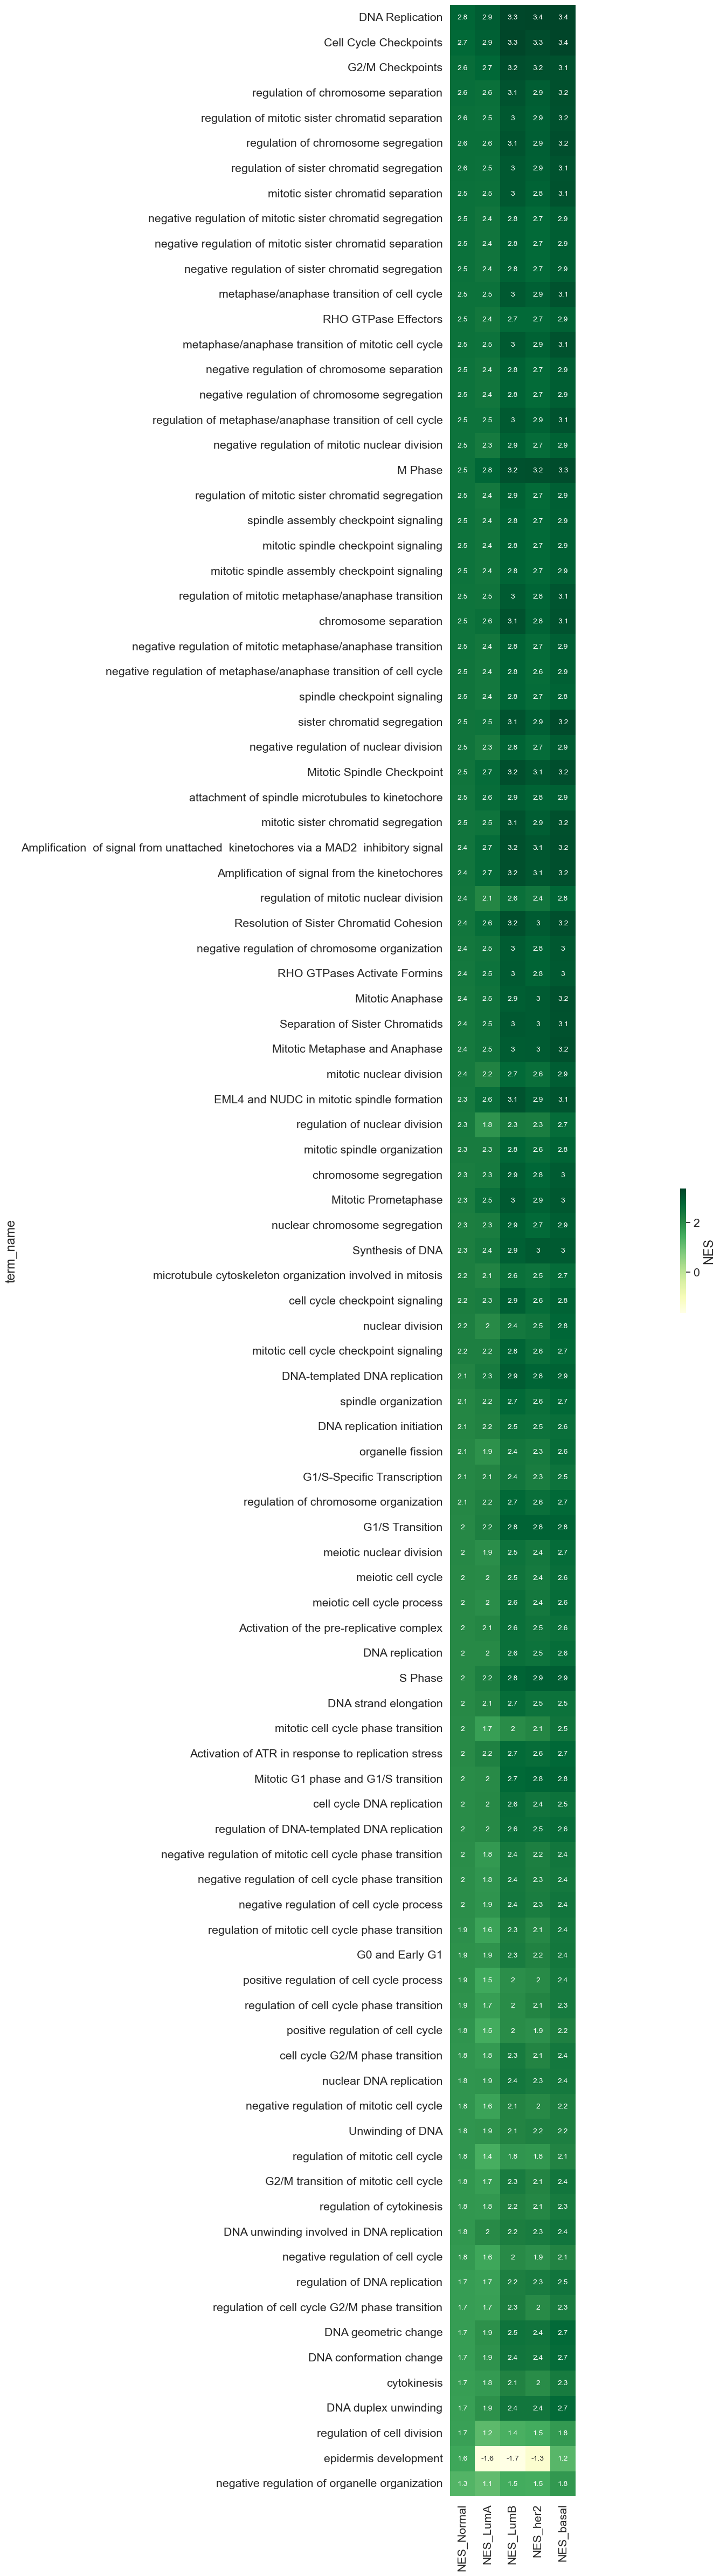

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(50,60))
sns.heatmap(all_NES_desc, square=True, annot = True,annot_kws={'size': 10}, cbar_kws={'shrink': 0.05, 'label': "NES"},cmap='YlGn')

In [145]:
%%R
filtered_gmt$term <- as.character(filtered_gmt$term)

In [146]:
%R -o filtered_gmt

In [147]:
logfc_Normal = pd.read_csv("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/Normal.csv",index_col=[0])
logfc_LumA = pd.read_csv("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/LumA.csv",index_col=[0])
logfc_LumB = pd.read_csv("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/LumB.csv",index_col=[0])
logfc_her2 = pd.read_csv("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/her2.csv",index_col=[0])
logfc_basal = pd.read_csv("C:/Users/javte/Documents/SSEF project/datasets/foldchange/new_fc/basal.csv",index_col=[0])
logdfs = [logfc_Normal,logfc_LumA,logfc_LumB,logfc_her2,logfc_basal]
for logdf in logdfs:
    logdf.rename(columns={"genes.1":"genes1"},inplace=True)
    logdf.genes1 = logdf.genes1.apply(lambda x: x.split('.', 1)[0])
    logdf.set_index('genes1',inplace=True)

In [148]:
def getGeneList(gene):
    result = filtered_gmt.query('term==@gene')
    genelist = result.gene.to_list()
    return genelist
def listQuery(genelist):
    logdfs = [logfc_Normal,logfc_LumA,logfc_LumB,logfc_her2,logfc_basal]
    for logdf in logdfs:
        logdf.query('genes1 == @genelist',inplace=True)
        logdf.sort_values(by='logFC',ascending=False,inplace=True)
    return logdfs

In [149]:
results = listQuery(getGeneList("GO:0008544"))

In [150]:
to_concat=[results[0].iloc[:,0:1],results[1].logFC,results[2].logFC,results[3].logFC,results[4].logFC]
logfc_df = pd.concat(to_concat,axis=1)

In [151]:
logfc_df.columns=[['NormalLike','LumA','LumB','her2','basal']]

In [152]:
logfc_df

NormalLike      LumA      LumB      her2     basal
genes1                                                            
ENSG00000105141   3.167507  0.944450  2.119334  6.721262  3.515053
ENSG00000106689   2.987147  2.282265  3.512106  4.546175  4.223205
ENSG00000122641   2.769743  3.209850  3.229711  3.511570  2.938395
ENSG00000143556   2.694928  0.469855  0.161016  5.420932  3.186533
ENSG00000178372   2.604527 -0.106716 -0.394233  3.871141  2.916030
...                    ...       ...       ...       ...       ...
ENSG00000136826  -1.821171 -2.222869 -2.857910 -2.316139 -2.911047
ENSG00000165124  -2.072583 -2.816056 -3.613550 -3.463231 -4.410297
ENSG00000070193  -2.173397 -1.794088 -3.245021 -4.095595 -5.469224
ENSG00000104371  -2.177714 -2.514788 -3.272444 -3.211333 -2.645685
ENSG00000139304  -3.994191 -3.595015 -3.159942 -4.635894 -4.840403

[311 rows x 5 columns]

In [201]:
ensg_Normal = list(results[0].index)
ensg_LumA = list(results[1].index)
ensg_LumB = list(results[2].index)
ensg_her2 = list(results[3].index)
ensg_basal = list(results[4].index)
%R -i ensg_Normal
%R -i ensg_LumA
%R -i ensg_LumB
%R -i ensg_her2
%R -i ensg_basal

In [202]:
%%R
symbol_Normal <- gconvert(query = c(ensg_Normal), organism = 'hsapiens', target ='WIKIGENE')
symbol_LumA <- gconvert(query = c(ensg_LumA), organism = 'hsapiens', target ='WIKIGENE')
symbol_LumB <- gconvert(query = c(ensg_LumB), organism = 'hsapiens', target ='WIKIGENE')
symbol_her2 <- gconvert(query = c(ensg_her2), organism = 'hsapiens', target ='WIKIGENE')
symbol_basal <- gconvert(query = c(ensg_basal), organism = 'hsapiens', target ='WIKIGENE')

In [203]:
%R -o symbol_Normal
%R -o symbol_LumA
%R -o symbol_LumB
%R -o symbol_her2
%R -o symbol_basal

In [204]:
#function to write symbol
def writeSymbol(name, description):
    description_short = description.split('[', 1)[0]
    return name+': '+description_short

In [205]:
symbolDfs = [symbol_Normal, symbol_LumA, symbol_LumB, symbol_her2, symbol_basal]
for symbolDf in symbolDfs:
    symbolDf['symbol'] = symbolDf.apply(lambda x: writeSymbol(x['name'],x['description']), axis=1)

In [206]:
symbol_dict = symbolDfs[0].iloc[:,[1,7]]
symbol_dict_2 = symbol_dict.rename(columns={'input':'genes1'})
symbol_dict_index = symbol_dict_2.set_index('genes1')

In [212]:
to_add_symbols = [logfc_df,symbol_dict_index]
logfc_symbols = pd.concat(to_add_symbols, axis=1)
logfc_symbols.index.names = ['genes']
logfc_symbols.set_index('symbol',inplace=True)

In [234]:
logfc_symbols

(NormalLike,)   (LumA,)  \
symbol                                                                        
CASP14: caspase 14                                       3.167507  0.944450   
LHX2: LIM homeobox 2                                     2.987147  2.282265   
INHBA: inhibin subunit beta A                            2.769743  3.209850   
S100A7: S100 calcium binding protein A7                  2.694928  0.469855   
CALML5: calmodulin like 5                                2.604527 -0.106716   
...                                                           ...       ...   
KLF4: Kruppel like factor 4                             -1.821171 -2.222869   
SVEP1: sushi, von Willebrand factor type A, EGF...      -2.072583 -2.816056   
FGF10: fibroblast growth factor 10                      -2.173397 -1.794088   
DKK4: dickkopf WNT signaling pathway inhibitor 4        -2.177714 -2.514788   
PTPRQ: protein tyrosine phosphatase receptor ty...      -3.994191 -3.595015   

                                                     (LumB,)   (her2,)  \
symbol                                                                   
CASP14: caspase 14                                  2.119334  6.721262   
LHX2: LIM homeobox 2                                3.512106  4.546175   
INHBA: inhibin subunit beta A                       3.229711  3.511570   
S100A7: S100 calcium binding protein A7             0.161016  5.420932   
CALML5: calmodulin like 5                          -0.394233  3.871141   
...                                                      ...       ...   
KLF4: Kruppel like factor 4                        -2.857910 -2.316139   
SVEP1: sushi, von Willebrand factor type A, EGF... -3.613550 -3.463231   
FGF10: fibroblast growth factor 10                 -3.245021 -4.095595   
DKK4: dickkopf WNT signaling pathway inhibitor 4   -3.272444 -3.211333   
PTPRQ: protein tyrosine phosphatase receptor ty... -3.159942 -4.635894   

                                                    (basal,)  
symbol                                                        
CASP14: caspase 14                                  3.515053  
LHX2: LIM homeobox 2                                4.223205  
INHBA: inhibin subunit beta A                       2.938395  
S100A7: S100 calcium binding protein A7             3.186533  
CALML5: calmodulin like 5                           2.916030  
...                                                      ...  
KLF4: Kruppel like factor 4                        -2.911047  
SVEP1: sushi, von Willebrand factor type A, EGF... -4.410297  
FGF10: fibroblast growth factor 10                 -5.469224  
DKK4: dickkopf WNT signaling pathway inhibitor 4   -2.645685  
PTPRQ: protein tyrosine phosphatase receptor ty... -4.840403  

[311 rows x 5 columns]

In [235]:
logfc_symbols_1= logfc_symbols.query(
    "symbol.str.contains('epidermal')", engine="python")

In [1]:
%matplotlib inline
plt.subplots(figsize=(20,30))
sns.heatmap(logfc_symbols_1, square=True, annot = True,annot_kws={'size': 10}, cbar_kws={'shrink': 0.3, 'label': "log2 FC"},cmap='RdYlGn')

NameError: name 'plt' is not defined

In [230]:
%matplotlib inline
plt.subplots(figsize=(500,600))
plt.yticks(size=20)
sns.heatmap(logfc_symbols, square=True, annot = True,annot_kws={'size': 20}, cbar_kws={'shrink': 0.05, 'label': "log2 FC"},cmap='RdYlGn')

<AxesSubplot:ylabel='symbol'>